In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import gurobipy as gp
from gurobipy import GRB
from numpy.typing import NDArray

In [10]:
# 価格を生成する関数
def create_price(r_min: float, r_max: float, M: int) -> NDArray[np.float_]:
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.uniform(r_min, r_max, M)
    price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 2)

    return beta_star


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list

In [11]:
z = [0.6, 0.7, 0.8, 0.9, 1.0]

In [12]:
# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], prices_min: float, prices_max: float
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)

    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 予測を最適化

    # gurobiのモデルを作成
    model = gp.Model()

    # 変数を作成
    prices = model.addVars(M, lb=prices_min, ub=prices_max, vtype=GRB.CONTINUOUS, name="prices")

    # 目的関数を設定
    total_sales = 0
    for i in range(M):
        total_sales += gp.quicksum(coefs[i][j] * prices[j] for j in range(M)) + intercepts[i]
    model.setObjective(total_sales, GRB.MAXIMIZE)

    # 最適化
    model.optimize()

    optimal_sales = model.objVal

    # 価格を取得
    optimal_prices = [prices[i].x for i in range(M)]

    return optimal_sales, optimal_prices

In [13]:
# sales_functionの最適化を行う関数
def sales_optimize(
    M: int, alpha: NDArray[np.float_], beta: NDArray[np.float_], price_min: float, price_max: float
) -> tuple[float, NDArray[np.float_]]:
    # モデルの作成
    model = gp.Model()

    # 変数の作成
    prices = model.addVars(M, lb=price_min, ub=price_max, vtype=GRB.CONTINUOUS, name="prices")

    # 目的関数の設定
    objective = gp.quicksum(
        (alpha[m] + gp.quicksum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        * prices[m]
        for m in range(M)
    )

    model.setObjective(objective, GRB.MAXIMIZE)

    # 最適化
    model.optimize()

    # 結果を取得
    optimal_sales = model.objVal

    # 価格を取得
    optimal_prices = [prices[i].x for i in range(M)]

    return optimal_sales, optimal_prices

In [14]:
# CVを行う関数
def cross_validation(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    price_min: float,
    price_max: float,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # モデルの作成
        model = gp.Model()

        # 変数の作成
        prices = model.addVars(M, lb=price_min, ub=price_max, name="prices")

        # 目的関数の設定
        total_sales = 0
        for i in range(M):
            total_sales += gp.quicksum(coefs[i][j] * prices[j] for j in range(M)) + intercepts[i]
        model.setObjective(total_sales, GRB.MAXIMIZE)

        # 最適化
        model.optimize()

        # 結果を取得
        optimal_sales = np.array([prices[i].x for i in range(M)]).reshape(1, -1)

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)
        sales_hat = lr_hat.predict(optimal_sales).sum()
        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)

In [15]:
# このデータにおけるalpha,betaを作成
M = 20
alpha = alpha_star(M)
beta = beta_star(M, M)
r_m = 0.6
r_M = 1.0
# 価格を入れるリスト
price_list = []
# 売上を入れるリスト
sales_list = []

# 価格と対応する売上を500件生成
for i in range(500):
    price = create_price(r_m, r_M, M)
    price_list.append(price)
    sales = sales_function(price, alpha, beta)
    sales_list.append(sales)

X = np.array(price_list).astype(float)
y = np.array(sales_list).astype(float)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 20 columns and 0 nonzeros
Model fingerprint: 0xfd5d5d04
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 5e+01]
  Bounds range     [6e-01, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 20 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1438564e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.143856400e+02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thre

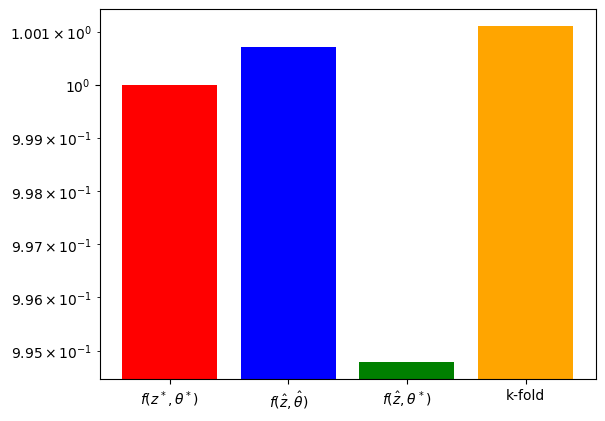

In [16]:
# predict_optimazeの結果を取得
predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, r_m, r_M)
# sales_optimizeの結果を取得
sales_optimize_sales, sales_optimize_prices = sales_optimize(M, alpha, beta, r_m, r_M)
# cross_validationの結果を取得
cross_validation_sales = cross_validation(X, y, M, 5, r_m, r_M)

# predictoptimize_salesをsales_functionに代入
predict_sales = sum(sales_function(predict_optimize_prices, alpha, beta))

# 結果を図示
plt.bar(
    [r"$f(z^*,\theta^*)$", r"$f(\hat{z},\hat\theta)$", r"$f(\hat{z},\theta^*)$", r"k-fold"],
    [
        sales_optimize_sales / sales_optimize_sales,
        predict_optimize_sales / sales_optimize_sales,
        predict_sales / sales_optimize_sales,
        cross_validation_sales / sales_optimize_sales,
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")

plt.show()
